In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright (C) 2016 Paul Brodersen <paulbrodersen+entropy_estimators@gmail.com>

# Author: Paul Brodersen <paulbrodersen+entropy_estimators@gmail.com>

# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 3
# of the License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.


"""
TODO:
- make python3 compatible
- fix code for p-norm 1 and 2 (norm argument currently ignored)
- write test for get_pid()
- get_pmi() with normalisation fails test
"""

import numpy as np
import itertools
from scipy.spatial import cKDTree
from scipy.special import gamma, digamma
from scipy.stats   import multivariate_normal, rankdata


log = np.log   # i.e. information measures are in nats
# log = np.log2  # i.e. information measures are in bits


def unit_interval(arr):
    return (arr - np.nanmin(arr, axis=0)[None,:]) / (np.nanmax(arr, axis=0) - np.nanmin(arr, axis=0))


def rank(arr):
    return np.apply_along_axis(rankdata, 0, arr)


def det(array_or_scalar):
    if array_or_scalar.size > 1:
        return np.linalg.det(array_or_scalar)
    else:
        return array_or_scalar


def get_h_mvn(x):

    """
    Computes the entropy of a multivariate Gaussian distribution:
    H(X) = (1/2) * log((2 * pi * e)^d * det(cov(X)))
    Arguments:
    ----------
    x: (n, d) ndarray
        n samples from a d-dimensional multivariate normal distribution
    Returns:
    --------
    h: float
        entropy H(X)
    """

    d = x.shape[1]
    h  = 0.5 * log((2 * np.pi * np.e)**d * det(np.cov(x.T)))
    return h


def get_mi_mvn(x, y):
    """
    Computes the mutual information I between two multivariate normal random
    variables, X and Y:
    I(X, Y) = H(X) + H(Y) - H(X, Y)
    Arguments:
    ----------
    x, y: (n, d) ndarrays
        n samples from d-dimensional multivariate normal distributions
    Returns:
    --------
    mi: float
        mutual information I(X, Y)
    """

    d = x.shape[1]

    # hx  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(x.T)))
    # hy  = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(y.T)))
    # hxy = 0.5 * log((2 * np.pi * np.e)**(2*d) * det(np.cov(x.T, y=y.T)))
    # mi = hx + hy - hxy

    # hx  = 0.5 * log(det(2*np.pi*np.e*np.cov(x.T)))
    # hy  = 0.5 * log(det(2*np.pi*np.e*np.cov(y.T)))
    # hxy = 0.5 * log(det(2*np.pi*np.e*np.cov(np.c_[x,y].T)))
    hx  = get_h_mvn(x)
    hy  = get_h_mvn(y)
    hxy = get_h_mvn(np.c_[x,y])
    mi = hx + hy - hxy

    # mi = 0.5 * (log(det(np.cov(x.T))) + log(det(np.cov(y.T))) - log(det(np.cov(np.c_[x,y].T))))

    return mi

def get_pmi_mvn(x, y, z):
    """
    Computes the partial mutual information PMI between two multivariate normal random
    variables, X and Y, while conditioning on a third MVN RV, Z:
    I(X;Y|Z) = H(X,Z) + H(Y,Z) - H(X, Y, Z) - H(Z)
    where:
    H(Z)     = (1/2) * log(det(2 * pi * e * cov(Z)))
    H(X,Z)   = (1/2) * log(det(2 * pi * e * cov(XZ)))
    H(Y,Z)   = (1/2) * log(det(2 * pi * e * cov(YZ)))
    H(X,Y,Z) = (1/2) * log(det(2 * pi * e * cov(XYZ)))
    Arguments:
    ----------
    x, y, z: (n, d) ndarrays
        n samples from d-dimensional multivariate normal distributions
    Returns:
    --------
    pmi: float
        partial mutual information I(X;Y|Z)
    """

    d = x.shape[1]
    hz   = 0.5 * log((2 * np.pi * np.e)**d     * det(np.cov(z.T)))
    hxz  = 0.5 * log((2 * np.pi * np.e)**(2*d) * det(np.cov(x.T, y=z.T)))
    hyz  = 0.5 * log((2 * np.pi * np.e)**(2*d) * det(np.cov(y.T, y=z.T)))
    hxyz = 0.5 * log((2 * np.pi * np.e)**(3*d) * det(np.cov(np.c_[x,y,z].T)))

    pmi = hxz + hyz - hxyz - hz
    return pmi

def get_h(x, k=1, norm=np.inf, min_dist=0.):
    """
    Estimates the entropy H of a random variable x (in nats) based on
    the kth-nearest neighbour distances between point samples.
    @reference:
    Kozachenko, L., & Leonenko, N. (1987). Sample estimate of the entropy of a random vector. Problemy Peredachi Informatsii, 23(2), 9–16.
    Arguments:
    ----------
    x: (n, d) ndarray
        n samples from a d-dimensional multivariate distribution
    k: int (default 1)
        kth nearest neighbour to use in density estimate;
        imposes smoothness on the underlying probability distribution
    norm: 1, 2, or np.inf (default np.inf)
        p-norm used when computing k-nearest neighbour distances
            1: absolute-value norm
            2: euclidean norm
            3: max norm
    min_dist: float (default 0.)
        minimum distance between data points;
        smaller distances will be capped using this value
    Returns:
    --------
    h: float
        entropy H(X)
    """

    n, d = x.shape

    # volume of the d-dimensional unit ball...
    # if norm == np.inf: # max norm:
    #     log_c_d = 0
    # elif norm == 2: # euclidean norm
    #     log_c_d = (d/2.) * log(np.pi) -log(gamma(d/2. +1))
    # elif norm == 1:
    #     raise NotImplementedError
    # else:
    #     raise NotImplementedError("Variable 'norm' either 1, 2 or np.inf")
    log_c_d = 0.

    kdtree = cKDTree(x)

    # query all points -- k+1 as query point also in initial set
    # distances, idx = kdtree.query(x, k + 1, eps=0, p=norm)
    distances, idx = kdtree.query(x, k + 1, eps=0, p=np.inf)
    distances = distances[:, -1]

    # enforce non-zero distances
    distances[distances < min_dist] = min_dist

    sum_log_dist = np.sum(log(2*distances)) # where did the 2 come from? radius -> diameter
    h = -digamma(k) + digamma(n) + log_c_d + (d / float(n)) * sum_log_dist

    return h

def get_mi(x, y, k=1, normalize=None, norm=np.inf, estimator='ksg'):
    """
    Estimates the mutual information (in nats) between two point clouds, x and y,
    in a D-dimensional space.
    I(X,Y) = H(X) + H(Y) - H(X,Y)
    @reference:
    Kraskov, Stoegbauer & Grassberger (2004). Estimating mutual information. PHYSICAL REVIEW E 69, 066138
    Arguments:
    ----------
    x, y: (n, d) ndarray
        n samples from d-dimensional multivariate distributions
    k: int (default 1)
        kth nearest neighbour to use in density estimate;
        imposes smoothness on the underlying probability distribution
    normalize: function or None (default None)
        if a function, the data pre-processed with the function before the computation
    norm: 1, 2, or np.inf (default np.inf)
        p-norm used when computing k-nearest neighbour distances
            1: absolute-value norm
            2: euclidean norm
            3: max norm
    min_dist: float (default 0.)
        minimum distance between data points;
        smaller distances will be capped using this value
    estimator: 'ksg' or 'naive' (default 'ksg')
        'ksg'  : see Kraskov, Stoegbauer & Grassberger (2004) Estimating mutual information, eq(8).
        'naive': entropies are calculated individually using the Kozachenko-Leonenko estimator implemented in get_h()
    Returns:
    --------
    mi: float
        mutual information I(X,Y)
    """

    if normalize:
        x = normalize(x)
        y = normalize(y)

    # construct state array for the joint process:
    xy = np.c_[x,y]

    if estimator == 'naive':
        # compute individual entropies
        hx  = get_h(x,  k=k, norm=norm)
        hy  = get_h(y,  k=k, norm=norm)
        hxy = get_h(xy, k=k, norm=norm)

        # compute mi
        mi = hx + hy - hxy

    elif estimator == 'ksg':

        # store data pts in kd-trees for efficient nearest neighbour computations
        # TODO: choose a better leaf size
        x_tree  = cKDTree(x)
        y_tree  = cKDTree(y)
        xy_tree = cKDTree(xy)

        # kth nearest neighbour distances for every state
        # query with k=k+1 to return the nearest neighbour, not counting the data point itself
        # dist, idx = xy_tree.query(xy, k=k+1, p=norm)
        dist, idx = xy_tree.query(xy, k=k+1, p=np.inf)
        epsilon = dist[:, -1]

        # for each point, count the number of neighbours
        # whose distance in the x-subspace is strictly < epsilon
        # repeat for the y subspace
        n = len(x)
        nx = np.empty(n, dtype=np.int)
        ny = np.empty(n, dtype=np.int)
        for ii in range(n):
            # nx[ii] = len(x_tree.query_ball_point(x_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            # ny[ii] = len(y_tree.query_ball_point(y_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            nx[ii] = len(x_tree.query_ball_point(x_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1
            ny[ii] = len(y_tree.query_ball_point(y_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1

        mi = digamma(k) - np.mean(digamma(nx+1) + digamma(ny+1)) + digamma(n) # version (1)
        # mi = digamma(k) -1./k -np.mean(digamma(nx) + digamma(ny)) + digamma(n) # version (2)

    elif estimator == 'lnc':
        # TODO: (only if you can find some decent explanation on how to set alpha!)
        raise NotImplementedError("Estimator is one of 'naive', 'ksg'; currently: {}".format(estimator))

    else:
        raise NotImplementedError("Estimator is one of 'naive', 'ksg'; currently: {}".format(estimator))

    return mi

def get_pmi(x, y, z, k=1, normalize=None, norm=np.inf, estimator='fp'):
    """
    Estimates the partial mutual information (in nats), i.e. the
    information between two point clouds, x and y, in a D-dimensional
    space while conditioning on a third variable z.
    I(X,Y|Z) = H(X,Z) + H(Y,Z) - H(X,Y,Z) - H(Z)
    The estimators are based on:
    @reference:
    Frenzel & Pombe (2007) Partial mutual information for coupling analysis of multivariate time series
    Poczos & Schneider (2012) Nonparametric Estimation of Conditional Information and Divergences
    Arguments:
    ----------
    x, y, z: (n, d) ndarray
        n samples from d-dimensional multivariate distributions
    k: int (default 1)
        kth nearest neighbour to use in density estimate;
        imposes smoothness on the underlying probability distribution
    normalize: function or None (default None)
        if a function, the data pre-processed with the function before the computation
    norm: 1, 2, or np.inf (default np.inf)
        p-norm used when computing k-nearest neighbour distances
            1: absolute-value norm
            2: euclidean norm
            3: max norm
    estimator: 'fp', 'ps' or 'naive' (default 'fp')
        'naive': entropies are calculated individually using the Kozachenko-Leonenko estimator implemented in get_h()
        'fp'   : Frenzel & Pombe estimator (effectively the KSG-estimator for mutual information)
    Returns:
    --------
    pmi: float
        partial mutual information I(X,Y;Z)
    """

    if normalize:
        x = normalize(x)
        y = normalize(y)
        z = normalize(z)

    # construct state array for the joint processes:
    xz  = np.c_[x,z]
    yz  = np.c_[y,z]
    xyz = np.c_[x,y,z]

    if estimator == 'naive':
        # compute individual entropies
        # TODO: pass in min_dist
        hz   = get_h(z,   k=k, norm=norm)
        hxz  = get_h(xz,  k=k, norm=norm)
        hyz  = get_h(yz,  k=k, norm=norm)
        hxyz = get_h(xyz, k=k, norm=norm)

        pmi =  hxz + hyz - hxyz - hz

    elif estimator == 'fp':

        # construct k-d trees
        z_tree   = cKDTree(z)
        xz_tree  = cKDTree(xz)
        yz_tree  = cKDTree(yz)
        xyz_tree = cKDTree(xyz)

        # kth nearest neighbour distances for every state
        # query with k=k+1 to return the nearest neighbour, not the data point itself
        # dist, idx = xyz_tree.query(xyz, k=k+1, p=norm)
        dist, idx = xyz_tree.query(xyz, k=k+1, p=np.inf)
        epsilon = dist[:, -1]

        # for each point, count the number of neighbours
        # whose distance in the relevant subspace is strictly < epsilon
        n = len(x)
        nxz = np.empty(n, dtype=np.int)
        nyz = np.empty(n, dtype=np.int)
        nz  = np.empty(n, dtype=np.int)

        for ii in range(n):
            # nz[ii]  = len( z_tree.query_ball_point( z_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            # nxz[ii] = len(xz_tree.query_ball_point(xz_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            # nyz[ii] = len(yz_tree.query_ball_point(yz_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            nz[ii]  = len( z_tree.query_ball_point( z_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1
            nxz[ii] = len(xz_tree.query_ball_point(xz_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1
            nyz[ii] = len(yz_tree.query_ball_point(yz_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1

        pmi = digamma(k) + np.mean(digamma(nz +1) -digamma(nxz +1) -digamma(nyz +1))

    elif estimator == 'ps':
        # (I am fairly sure that) this is the correct implementation of the estimator,
        # but the estimators is just crap.

        # construct k-d trees
        xz_tree  = cKDTree(xz,  leafsize=2*k)
        yz_tree  = cKDTree(yz,  leafsize=2*k)

        # determine k-nn distances
        n = len(x)
        rxz = np.empty(n, dtype=np.int)
        ryz = np.empty(n, dtype=np.int)

        # rxz, dummy = xz_tree.query(xz, k=k+1, p=norm) # +1 to account for distance to itself
        # ryz, dummy = yz_tree.query(xz, k=k+1, p=norm) # +1 to account for distance to itself; xz NOT a typo
        rxz, dummy = xz_tree.query(xz, k=k+1, p=np.inf) # +1 to account for distance to itself
        ryz, dummy = yz_tree.query(xz, k=k+1, p=np.inf) # +1 to account for distance to itself; xz NOT a typo

        pmi = yz.shape[1] * np.mean(log(ryz[:,-1]) - log(rxz[:,-1])) # + log(n) -log(n-1) -1.

    else:
        raise NotImplementedError("Estimator one of 'naive', 'fp', 'ps'; currently: {}".format(estimator))

    return pmi

def get_imin(x1, x2, y, k=1, normalize=None, norm=np.inf):
    """
    Estimates the average specific information (in nats) between a random variable Y
    and two explanatory variables, X1 and X2.
    I_min(Y; X1, X2) = \sum_{y \in Y} p(y) min_{X \in {X1, X2}} I_spec(y; X)
    where
    I_spec(y; X) = \sum_{x \in X} p(x|y) \log(p(y|x) / p(x))
    @reference:
    Williams & Beer (2010). Nonnegative Decomposition of Multivariate Information. arXiv:1004.2515v1
    Kraskov, Stoegbauer & Grassberger (2004). Estimating mutual information. PHYSICAL REVIEW E 69, 066138
    Arguments:
    ----------
    x1, x2, y: (n, d) ndarray
        n samples from d-dimensional multivariate distributions
    k: int (default 1)
        kth nearest neighbour to use in density estimate;
        imposes smoothness on the underlying probability distribution
    normalize: function or None (default None)
        if a function, the data pre-processed with the function before the computation
    norm: 1, 2, or np.inf (default np.inf)
        p-norm used when computing k-nearest neighbour distances
            1: absolute-value norm
            2: euclidean norm
            3: max norm
    Returns:
    --------
    i_min: float
        average specific information I_min(Y; X1, X2)
    """

    if normalize:
        y = normalize(y)

    y_tree  = cKDTree(y)

    n = len(y)
    i_spec = np.zeros((2, n))

    for jj, x in enumerate([x1, x2]):

        if normalize:
            x = normalize(x)

        # construct state array for the joint processes:
        xy = np.c_[x,y]

        # store data pts in kd-trees for efficient nearest neighbour computations
        # TODO: choose a better leaf size
        x_tree  = cKDTree(x)
        xy_tree = cKDTree(xy)

        # kth nearest neighbour distances for every state
        # query with k=k+1 to return the nearest neighbour, not counting the data point itself
        # dist, idx = xy_tree.query(xy, k=k+1, p=norm)
        dist, idx = xy_tree.query(xy, k=k+1, p=np.inf)
        epsilon = dist[:, -1]

        # for each point, count the number of neighbours
        # whose distance in the x-subspace is strictly < epsilon
        # repeat for the y subspace
        nx = np.empty(n, dtype=np.int)
        ny = np.empty(n, dtype=np.int)
        for ii in xrange(N):
            # nx[ii] = len(x_tree.query_ball_point(x_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            # ny[ii] = len(y_tree.query_ball_point(y_tree.data[ii], r=epsilon[ii], p=norm)) - 1
            nx[ii] = len(x_tree.query_ball_point(x_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1
            ny[ii] = len(y_tree.query_ball_point(y_tree.data[ii], r=epsilon[ii], p=np.inf)) - 1

        i_spec[jj] = digamma(k) - digamma(nx+1) + digamma(ny+1) + digamma(n) # version (1)

    i_min = np.mean(np.min(i_spec, 0))

    return i_min

def get_pid(x1, x2, y, k=1, normalize=None, norm=np.inf):

    """
    Estimates the partial information decomposition (in nats) between a random variable Y
    and two explanatory variables, X1 and X2.
    I(X1, X2; Y) = synergy + unique_{X1} + unique_{X2} + redundancy
    redundancy = I_{min}(X1, X2; Y)
    unique_{X1} = I(X1; Y) - redundancy
    unique_{X2} = I(X2; Y) - redundancy
    synergy = I(X1, X2; Y) - I(X1; Y) - I(X2; Y) + redundancy
    The estimator is based on:
    @reference:
    Williams & Beer (2010). Nonnegative Decomposition of Multivariate Information. arXiv:1004.2515v1
    Kraskov, Stoegbauer & Grassberger (2004). Estimating mutual information. PHYSICAL REVIEW E 69, 066138
    For a critique of I_min as a redundancy measure, see
    Bertschinger et al. (2012). Shared Information – New Insights and Problems in Decomposing Information in Complex Systems. arXiv:1210.5902v1
    Griffith & Koch (2014). Quantifying synergistic mutual information. arXiv:1205.4265v6
    Arguments:
    ----------
    x1, x2, y: (n, d) ndarray
        n samples from d-dimensional multivariate distributions
    k: int (default 1)
        kth nearest neighbour to use in density estimate;
        imposes smoothness on the underlying probability distribution
    normalize: function or None (default None)
        if a function, the data pre-processed with the function before the computation
    norm: 1, 2, or np.inf (default np.inf)
        p-norm used when computing k-nearest neighbour distances
            1: absolute-value norm
            2: euclidean norm
            3: max norm
    Returns:
    --------
    synergy: float
        information about Y encoded by the joint state of x1 and x2
    unique_x1: float
        information about Y encoded uniquely by x1
    unique_x2: float
        information about Y encoded uniquely by x2
    redundancy: float
        information about Y encoded by either x1 or x2
    """

    mi_x1y     = get_mi(x1,            y, k=k, normalize=normalize, norm=norm)
    mi_x2y     = get_mi(x2,            y, k=k, normalize=normalize, norm=norm)
    mi_x1x2y   = get_mi(np.c_[x1, x2], y, k=k, normalize=normalize, norm=norm)
    redundancy = get_imin(x1, x2,      y, k=k, normalize=normalize, norm=norm)

    unique_x1 = mi_x1y - redundancy
    unique_x2 = mi_x2y - redundancy
    synergy = mi_x1x2y - mi_x1y - mi_x2y + redundancy

    return synergy, unique_x1, unique_x2, redundancy

# --------------------------------------------------------------------------------
def get_mvn_data(total_rvs, dimensionality=2, scale_sigma_offdiagonal_by=1., total_samples=1000):
    data_space_size = total_rvs * dimensionality

    # initialise distribution
    mu = np.random.randn(data_space_size)
    sigma = np.random.rand(data_space_size, data_space_size)
    # sigma = 1. + 0.5*np.random.randn(data_space_size, data_space_size)

    # ensures that sigma is positive semi-definite
    sigma = np.dot(sigma.transpose(), sigma)

    # scale off-diagonal entries -- might want to change that to block diagonal entries
    # diag = np.diag(sigma).copy()
    # sigma *= scale_sigma_offdiagonal_by
    # sigma[np.diag_indices(len(diag))] = diag

    # scale off-block diagonal entries
    d = dimensionality
    for ii, jj in itertools.product(range(total_rvs), repeat=2):
        if ii != jj:
            sigma[d*ii:d*(ii+1), d*jj:d*(jj+1)] *= scale_sigma_offdiagonal_by

    # get samples
    samples = multivariate_normal(mu, sigma).rvs(total_samples)

    return [samples[:,ii*d:(ii+1)*d] for ii in range(total_rvs)]

def test_get_h(k=5, norm=np.inf):
    X, = get_mvn_data(total_rvs=1,
                      dimensionality=2,
                      scale_sigma_offdiagonal_by=1.,
                      total_samples=1000)

    analytic = get_h_mvn(X)
    kozachenko = get_h(X, k=k, norm=norm)

    print("analytic result: {:.5f}".format(analytic))
    print("K-L estimator:   {:.5f}".format(kozachenko))

def test_get_mi(k=5, normalize=None, norm=np.inf):

    X, Y = get_mvn_data(total_rvs=2,
                        dimensionality=2,
                        scale_sigma_offdiagonal_by=1., # 0.1, 0.
                        total_samples=10000)

    # solutions
    analytic = get_mi_mvn(X, Y)
    naive = get_mi(X, Y, k=k, normalize=normalize, norm=norm, estimator='naive')
    ksg   = get_mi(X, Y, k=k, normalize=normalize, norm=norm, estimator='ksg')

    print("analytic result:  {:.5f}".format(analytic))
    print("naive estimator:  {:.5f}".format(naive))
    print("KSG estimator:    {:.5f}".format(ksg))
    print

    print("naive - analytic: {:.5f}".format(naive - analytic))
    print("ksg   - analytic: {:.5f}".format(ksg   - analytic))
    print

    print("naive / analytic: {:.5f}".format(naive / analytic))
    print("ksg   / analytic: {:.5f}".format(ksg   / analytic))
    print

    # for automated testing:
    assert np.isclose(analytic, naive, rtol=0.1, atol=0.1), "Naive MI estimate strongly differs from expectation!"
    assert np.isclose(analytic, ksg,   rtol=0.1, atol=0.1), "KSG MI estimate strongly differs from expectation!"

def test_get_pmi(k=5, normalize=None, norm=np.inf):

    X, Y, Z = get_mvn_data(total_rvs=3,
                           dimensionality=2,
                           scale_sigma_offdiagonal_by=1.,
                           total_samples=10000)

    # solutions
    analytic = get_pmi_mvn(X, Y, Z)
    naive    = get_pmi(X, Y, Z, k=k, normalize=normalize, norm=norm, estimator='naive')
    fp       = get_pmi(X, Y, Z, k=k, normalize=normalize, norm=norm, estimator='fp')

    print("analytic result : {:.5f}".format(analytic))
    print("naive estimator : {:.5f}".format(naive))
    print("FP estimator    : {:.5f}".format(fp))
    print

    # for automated testing:
    assert np.isclose(analytic, naive, rtol=0.5, atol=0.5), "Naive MI estimate strongly differs from expectation!"
    assert np.isclose(analytic, fp,    rtol=0.5, atol=0.5), "FP MI estimate strongly differs from expectation!"

def test_get_pid(k=5, normalize=None, norm=np.inf):
    # rdn -> only redundant information

    # unq -> only unique information

    # xor -> only synergistic information

    pass

In [5]:
import numpy
from entropy_estimators import continuous

# create some multivariate normal test data
X, = continous.get_mvn_data(total_rvs=1,        # number of random variables
                            dimensionality=2,   # dimensionality of each RV
                            total_samples=1000) # samples

# compute the entropy from the determinant of the multivariate normal distribution:
analytic = continuous.get_h_mvn(X)

# compute the entropy using the k-nearest neighbour approach
# developed by Kozachenko and Leonenko (1987):
kozachenko = continuous.get_h(X, k=5)

print("analytic result: {: .5f}".format(analytic))
print("K-L estimator: {: .5f}".format(kozachenko))

ModuleNotFoundError: No module named 'entropy_estimators'

Code: https://github.com/JaeDukSeo/entropy_estimators

In [3]:
import numpy as np
import matplotlib.pyplot as plt

[0 0]
[[0 0]
 [0 0]]


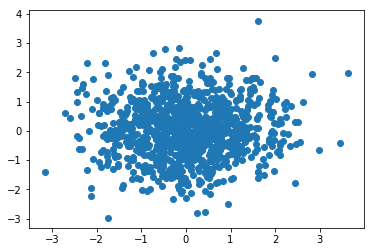

In [19]:

mean = np.array([0,0])
std  = np.diag(np.array([1,1]))
print(mean)
print(np.diag(mean))
data = np.random.multivariate_normal(mean,std,1000)
plt.scatter(data[:,0],data[:,1])
plt.show()

[0 0]
[[0 0]
 [0 0]]


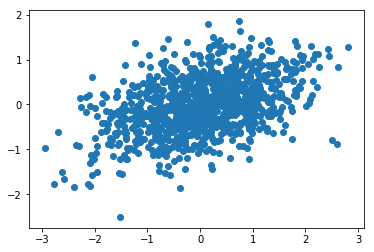

In [23]:

mean = np.array([0,0])
std  = np.array([
    [1,0.3],
    [0.3,0.4]
])
print(mean)
print(np.diag(mean))
data = np.random.multivariate_normal(mean,std,1000)
plt.scatter(data[:,0],data[:,1])
plt.show()